In [27]:
from ToxicTextsDataset import ToxicTextsDataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data as td

### Simple classifiers

In [5]:
df = pd.read_csv('train.csv')
voc_size = 10000
vectorizer = TfidfVectorizer(max_features=voc_size, analyzer='word', max_df = .95, min_df=.01)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1], df.iloc[:,2:], test_size=.2)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# def learn_chains(clf, num_chains, X_train, X_test, y_train, y_test):
    
#     # Train 'num_chain' chains
#     # Each chain consists of 6 binary classiers
#     chains = [ClassifierChain(clf, order='random', random_state=i) for i in range(num_chains)]
#     for k, chain in enumerate(chains):
#         print('fitting chain {}...'.format(k+1))
#         chain.fit(X_train, y_train)
#     print('Chains fitted!')
    
#     y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
#     chain_scores = [f1_score(y_test, y >= .5, average='weighted') for y in y_pred_chains]
    
#     # Ensemble of chains
#     y_pred_ensemble = y_pred_chains.mean(axis=0)
#     ensemble_score = f1_score(y_test,  y_pred_ensemble >= .5, average='weighted')    
#     return model_scores


fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
Done!


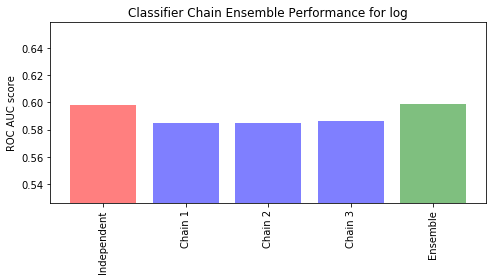

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
Done!


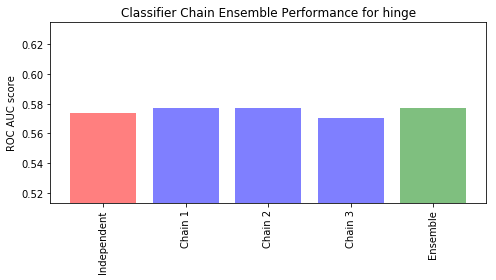

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
Done!


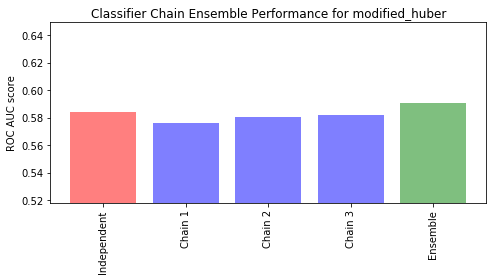

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
Done!


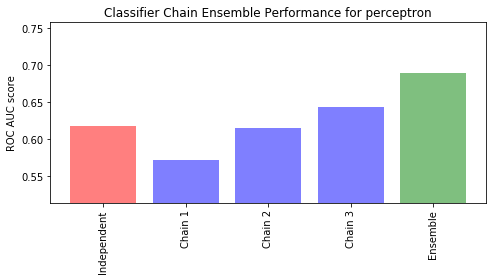

In [7]:
loss = ['log', 'hinge','modified_huber', 'perceptron']
num_chains = 3
ovr_score = []
chain_scores = [[] for i in range(len(loss))]
ensemble_score = []

for j, loss in enumerate(loss):
    # Independent
    clf = SGDClassifier(loss = loss, tol = 1e-10, penalty = 'l1', n_jobs=-1, max_iter=10000)
    ovr = OneVsRestClassifier(clf)
    print('fitting ovr...')
    ovr.fit(X_train, y_train)
    y_pred_ovr = ovr.predict(X_test)
    ovr_score.append(roc_auc_score(y_test, y_pred_ovr))

    # Chains
    chains = [ClassifierChain(clf, order='random', random_state=i) for i in range(num_chains)]

    for k, chain in enumerate(chains):
        print('fitting chain {}...'.format(k))
        chain.fit(X_train, y_train)
    print('Done!')
    
    y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
    chain_scores[j] = [roc_auc_score(y_test, y_pred_chain)
                         for y_pred_chain in y_pred_chains]

    y_pred_ensemble = y_pred_chains.mean(axis=0)
    ensemble_score.append(roc_auc_score(y_test,  y_pred_ensemble))

    model_scores = [ovr_score[j]] + chain_scores[j] + [ensemble_score[j]]
    

    model_names = ['Independent'] + ['Chain {}'.format(c+1) for c in range(num_chains)] + ['Ensemble']

    x_pos = np.arange(len(model_names))

# # Plot the Jaccard similarity scores for the independent model, each of the
# # chains, and the ensemble (note that the vertical axis on this plot does
# # not begin at 0).

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_title('Classifier Chain Ensemble Performance for {}'.format(loss))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation='vertical')
    ax.set_ylabel('ROC AUC score')
    ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
    colors = ['r'] + ['b'] * len(chain_scores[j]) + ['g']
    ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
    plt.tight_layout()
    plt.show()

In [ ]:
y_pred_chains

### NN

Generating vocabulary... Completed
Creating train dataset... Completed
Creating validation dataset... Completed


In [75]:
class LSTMBinary(nn.Module):
    def __init__(self, 
                 vocab_size=20000, 
                 embedding_dim = 100, 
                 hidden_dim=64, 
                 batch_size=10, 
                 conv_channels=32, 
                 use_cuda=True,
                 num_of_cl_features=4):
        """
            A model from paper "A Convolutional Attention Model for Text Classification" 
            by Jiachen Du, Lin Gui, Ruifeng Xu, Yulan He 
            http://tcci.ccf.org.cn/conference/2017/papers/1057.pdf
            With modified outter layer (softmax -> sigmoid) for multilabel classification
            and added character level features
            
        """
        super(LSTMBinary, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.conv_channels = conv_channels
        self.use_cuda = use_cuda
        self.num_of_cl_features = num_of_cl_features
        
        if(self.use_cuda):
            self.embeddings = nn.Embedding(vocab_size, embedding_dim=embedding_dim).cuda()
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim // 2, 
                            num_layers=1, bidirectional=True, batch_first=True).cuda()
                 # // 2 is because we would like to concat hidden states, 
                # calculated from both sides of LSTM and aquire exactly hidden_dim
            
            self.conv = nn.Conv1d(in_channels=embedding_dim, 
                                  out_channels=conv_channels, 
                                  kernel_size=5, 
                                  padding=2).cuda()
    
            self.linear = nn.Linear(conv_channels, 1).cuda()
            self.linear_final = nn.Linear(hidden_dim + num_of_cl_features, 6).cuda() 
            # we have 6 classes to predict
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim // 2, 
                            num_layers=1, bidirectional=True, batch_first=True)
            
            self.conv = nn.Conv1d(in_channels=embedding_dim, 
                                  out_channels=conv_channels, 
                                  kernel_size=5, 
                                  padding=2)
    
            self.linear = nn.Linear(conv_channels, 1)
            self.linear_final = nn.Linear(hidden_dim + num_of_cl_features, 6) # we have 6 classes to predict
            
        self.init_hidden()
        
        
    def init_hidden(self):
        if(self.use_cuda):
            self.hidden = (Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)).cuda(), 
                           Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)).cuda())
        else:
            self.hidden = (Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)), 
                           Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)))
    
    def forward(self, input_seq, cl_features=None):
        embed = self.embeddings(input_seq)
        output, _ = self.lstm(embed, self.hidden)
        
        conv_out = self.conv(embed.permute(0, 2, 1))
        
        attention_tensor = torch.mean(conv_out, dim=1)
        
        features = torch.sum(output * attention_tensor.resize(attention_tensor.data.shape[0], attention_tensor.data.shape[1], 1), dim=1)
        
        if(cl_features is not None and self.num_of_cl_features == cl_features.data.shape[1]):
            features = torch.cat((features, cl_features), dim=1)
        elif(cl_features is not None and self.num_of_cl_features != cl_features.data.shape[1]):
            print("""Recieved unexpected number of character level features. 
                     Model expected to recieve {} features, but received {}. 
                     Check model constructor or sample passed in forward""".format(self.num_of_cl_features, cl_features.data.shape[1]))
            raise ValueError()
        elif(cl_features is None and self.num_of_cl_features > 0):
            print("""Model expected to recieve {} features, but received None. 
                     Check model constructor or sample passed in forward""".format(self.num_of_cl_features))
            raise ValueError()
            
        predictions = nn.functional.softmax(self.linear_final(features), dim = 1)
        
        return predictions

In [80]:
batch_size = 6
use_cuda = False
validation_size = 0.15
vocab_size = 3000
n_train_batches = 1000
n_valid_batches = 500

dataset = ToxicTextsDataset(n_test_batches=1, 
                            n_train_batches=n_train_batches, 
                            n_valid_batches=n_valid_batches,
                            valid_size=validation_size,
                            test_size=0.,
                            batch_size=batch_size, 
                            vocab_size=vocab_size, 
                            verbose=1,
                            use_cuda = use_cuda)

Generating vocabulary... Completed
Creating train dataset... Completed
Creating validation dataset... Completed


In [ ]:
lr = 1e-3
weight_decay = 1e-5
embedding_dim = 200
hidden_dim = 10
conv_channels = 32


epochs = 15

train_stats = {'train_loss':[0], 'valid_loss':[0], 'roc_auc_score':[]}

model = LSTMBinary(vocab_size=vocab_size, 
                   embedding_dim = embedding_dim, 
                   hidden_dim=hidden_dim, 
                   conv_channels=conv_channels,
                               batch_size=batch_size, 
                               use_cuda=use_cuda)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if(use_cuda): loss_function = nn.MultiLabelSoftMarginLoss().cuda()
else: loss_function = nn.MultiLabelSoftMarginLoss()


start = time.time()
for i in range(epochs):

    all_predictions = Variable(torch.zeros(1, 6))
    all_true_labels = Variable(torch.zeros(1, 6))

    for mode in ['train', 'valid']:
        dataset.mode = mode
        dataset.shuffle()
        for sample in dataset:
            if(mode == 'train'):
                optimizer.zero_grad()
                model.init_hidden()

                pred = model.forward(sample['input'], sample['cl_features'])
                loss = loss_function(pred, sample['labels'])
                loss.backward()
                optimizer.step()
                train_stats['train_loss'][-1] += loss.data[0]
            else:
                model.init_hidden()
                pred = model.forward(sample['input'], sample['cl_features'])
                train_stats['valid_loss'][-1] += loss_function(pred, sample['labels']).data[0]

            all_predictions = torch.cat((all_predictions, pred.cpu()))
            all_true_labels = torch.cat((all_true_labels, sample['labels'].cpu()))

            
        all_predictions = all_predictions.data.numpy()[0]
        all_true_labels = all_true_labels.data.numpy()[0]
            
        train_stats['roc_auc_score'].append(roc_auc_score(all_true_labels, all_predictions))
            
            
        print('Epoch {:03d}; train loss = {:4.2f}; validation loss = {:2.2f}; validation roc auc score= {:0.2f}; ETA = {:3.0f} s\n'.format(i, 
                                                                              train_stats['train_loss'][-1], 
                                                                              train_stats['valid_loss'][-1], 
                                                                              train_stats['roc_auc_score'][-1],
                                                                             (epochs - i)*(time.time() - start)/(i+1)))

In [84]:
np.unique(sample['input'].data.numpy(), axis = 0).shape[0]
#sample['input'].data.numpy()
roc_auc_score(all_true_labels[0], all_predictions[0])

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [59]:

dataset.mode = 'train'
dataset.shuffle()
count = 0
count_same = 0
for i, sample in enumerate(dataset):
    if np.unique(sample['input'].data.numpy(), axis = 0).shape[0] == 1:
        count_same += 1
    else:
        count += 1
print(count, count_same)

1999 993


In [62]:
emb = nn.Embedding(vocab_size, embedding_dim=embedding_dim)

In [67]:
#emb(sample['input'])
sample['input']

Variable containing:

Columns 0 to 12 
   29  9999  2214   860  7357     6  5498     3  8971  9999   341     7   103
 7333  9164  8155   105     6  9586  2562  8469  8520  2433  9321  1283  9847
   29  9999  2214   860  7357     6  5498     3  8971  9999   341     7   103

Columns 13 to 25 
 4552     0     0   113   146  2596  9847  4048  7658  9999  5002   287  6235
 9999     0  9766  7140  7658  9586  2562    25    47  9164    22   122   113
 4552     0     0   113   146  2596  9847  4048  7658  9999  5002   287  6235

Columns 26 to 38 
 9999  9999     0  1007     0   625  9847  2767  9999  6458   982   141   321
 9586  2562  9847  4611  7682  7895   575   807     1  6567  7140   301  9847
 9999  9999     0  1007     0   625  9847  2767  9999  6458   982   141   321

Columns 39 to 51 
    1  5616  7333  9164  8155  2538  6426     0  9164    62     1     7    33
 9999  9586  2562     1  6644  9321  9972  7682  7915   809    25    47  6426
    1  5616  7333  9164  8155  2538  6426     